In [1]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time
import ray
import dask

In [2]:
import pandas as pd
print(pd.__version__)

1.5.3


In [3]:
print(PATH_SENSOR)

/var/nfs_share/D#4/newdata


In [4]:
def aggregate_steps_by_hour(path_sensor):
    # Create an empty dataframe to store the results
    aggregated_data = pd.DataFrame(columns=['pcode', 'timestamp', 'step_count'])
    
    # Loop through each folder in the directory
    for pcode in range(1, 136):
        folder_name = f'P{str(pcode).zfill(3)}'
        folder_path = os.path.join(path_sensor, folder_name)
        
        if not os.path.isdir(folder_path):
            continue
        
        # Path to the Fitbit-StepCount.csv file
        file_path = os.path.join(folder_path, 'Fitbit-StepCount.csv')
        
        if not os.path.isfile(file_path):
            continue
        
        # Read the csv file
        step_data = pd.read_csv(file_path)
        
        # Convert timestamp to datetime
        step_data['timestamp'] = pd.to_datetime(step_data['timestamp'], unit='ms')
        
        # Set the timestamp as the index
        step_data.set_index('timestamp', inplace=True)
        
        # Resample the data to 1-hour intervals and sum the step counts
        hourly_data = step_data['value'].resample('H').sum().reset_index()
        
        # Add the pcode to the dataframe
        hourly_data['pcode'] = folder_name
        
        # Rename columns to match the required output
        hourly_data.rename(columns={'timestamp': 'timestamp', 'value': 'step_count'}, inplace=True)
        
        # Append the aggregated data to the final dataframe
        aggregated_data = pd.concat([aggregated_data, hourly_data], ignore_index=True)
    
    return aggregated_data

In [5]:
aggregated_step_count_data = aggregate_steps_by_hour(PATH_SENSOR)

In [6]:
aggregated_step_count_data

,pcode,timestamp,step_count
0,P001,2021-11-24 02:00:00,726
1,P001,2021-11-24 03:00:00,437
2,P001,2021-11-24 04:00:00,627
3,P001,2021-11-24 05:00:00,291
4,P001,2021-11-24 06:00:00,269
...,...,...,...
76371,P135,2022-01-05 03:00:00,148
76372,P135,2022-01-05 04:00:00,796
76373,P135,2022-01-05 05:00:00,30
76374,P135,2022-01-05 06:00:00,7


In [7]:
output_path = os.path.join('Intermediate', 'labels_1h.csv')
os.makedirs(os.path.dirname(output_path), exist_ok=True)
aggregated_step_count_data.to_csv(output_path)

EDA

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
input_path = os.path.join('Intermediate', 'labels_1h.csv')
labels_df = pd.read_csv(input_path)

In [60]:
labels_df = labels_df.drop(columns=['Unnamed: 0'])
print(labels_df.head())

  pcode            timestamp  step_count
0  P001  2021-11-24 02:00:00         726
1  P001  2021-11-24 03:00:00         437
2  P001  2021-11-24 04:00:00         627
3  P001  2021-11-24 05:00:00         291
4  P001  2021-11-24 06:00:00         269


In [61]:
# Display basic statistics
print(labels_df.describe())

         step_count
count  76376.000000
mean     323.528425
std      631.672542
min        0.000000
25%        0.000000
50%       33.000000
75%      339.000000
max     8244.000000


In [62]:
print(labels_df.isnull().sum())

pcode         0
timestamp     0
step_count    0
dtype: int64


In [63]:
labels_df['step_count'] = pd.to_numeric(labels_df['step_count'], errors='coerce')

In [64]:
finite_mask = np.isfinite(labels_df['step_count'])
if not finite_mask.all():
    print("Non-finite values detected and removed.")
    labels_df = labels_df[finite_mask]

In [65]:
zero_count = (labels_df['step_count'] == 0).sum()
print(zero_count)

26260


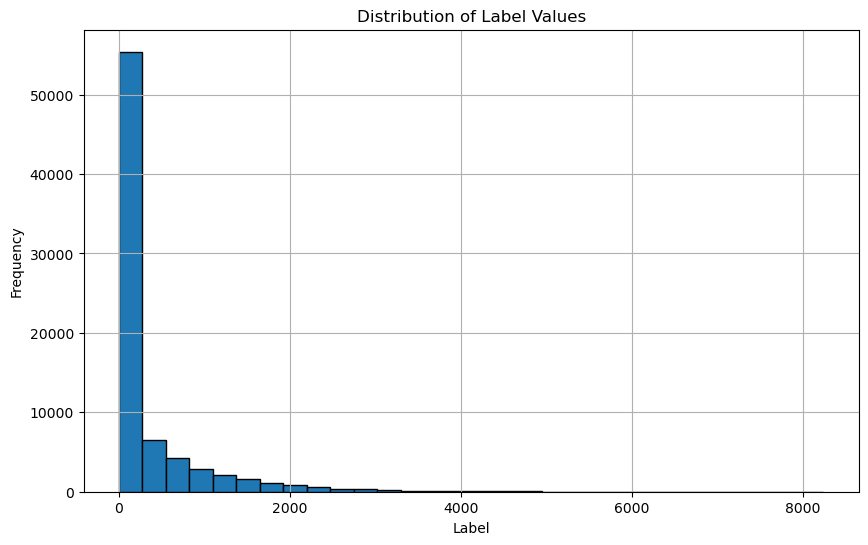

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(labels_df['step_count'], bins=30, edgecolor='black')
plt.title('Distribution of Label Values')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

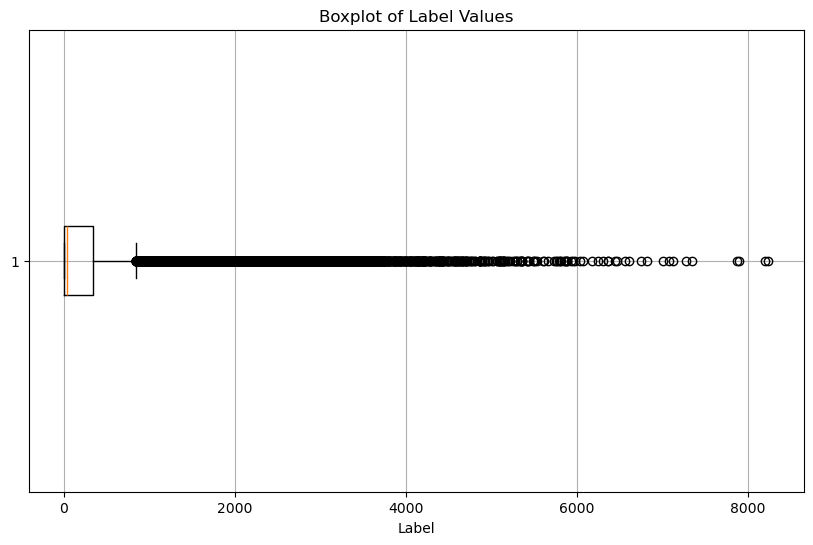

In [67]:
# Boxplot to visualize outliers
plt.figure(figsize=(10, 6))
plt.boxplot(labels_df['step_count'].dropna(), vert=False)
plt.title('Boxplot of Label Values')
plt.xlabel('Label')
plt.grid(True)
plt.show()

In [68]:
def remove_top_5_percent(group):
    upper_bound = group['step_count'].quantile(0.90)
    return group[group['step_count'] <= upper_bound]

In [69]:
filtered_df = labels_df.groupby('pcode').apply(remove_top_5_percent).reset_index(drop=True)

In [70]:
filtered_df

,pcode,timestamp,step_count
0,P001,2021-11-24 02:00:00,726
1,P001,2021-11-24 03:00:00,437
2,P001,2021-11-24 04:00:00,627
3,P001,2021-11-24 05:00:00,291
4,P001,2021-11-24 06:00:00,269
...,...,...,...
68702,P135,2022-01-05 02:00:00,0
68703,P135,2022-01-05 03:00:00,148
68704,P135,2022-01-05 05:00:00,30
68705,P135,2022-01-05 06:00:00,7


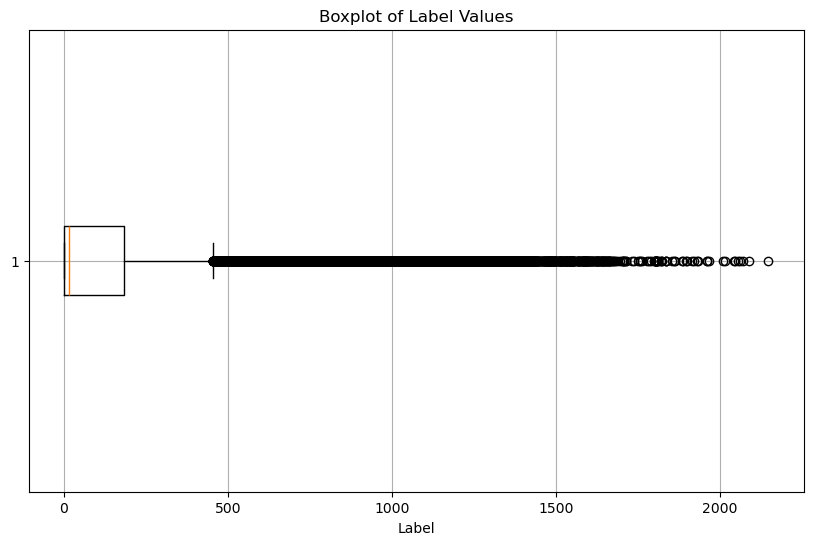

In [71]:
# Boxplot to visualize outliers
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_df['step_count'].dropna(), vert=False)
plt.title('Boxplot of Label Values')
plt.xlabel('Label')
plt.grid(True)
plt.show()

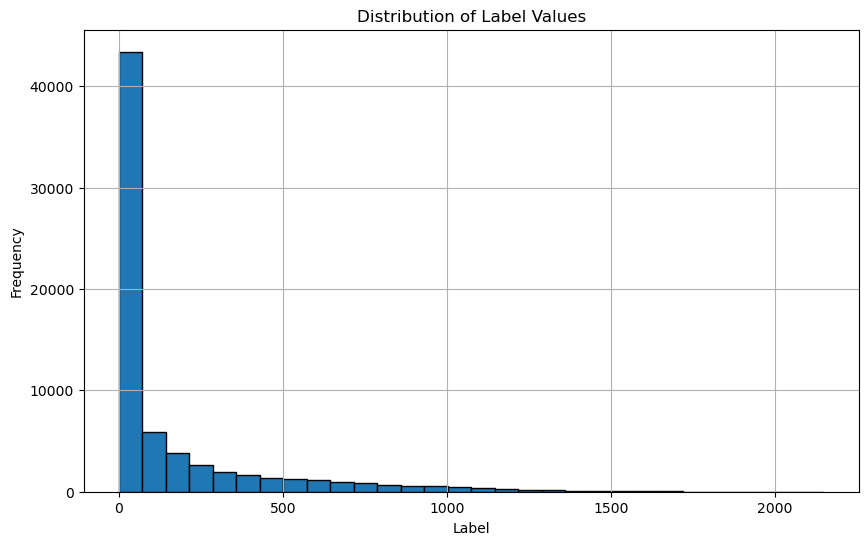

In [80]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['step_count'], bins=30, edgecolor='black')
plt.title('Distribution of Label Values')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [81]:
# Calculate personal means for each pcode
personal_means = filtered_df.groupby('pcode')['step_count'].mean().reset_index()
personal_means.columns = ['pcode', 'personal_mean']

In [82]:
merged_df = pd.merge(filtered_df, personal_means, on='pcode')

In [83]:
merged_df

,pcode,timestamp,step_count,personal_mean
0,P001,2021-11-24 02:00:00,726,165.835034
1,P001,2021-11-24 03:00:00,437,165.835034
2,P001,2021-11-24 04:00:00,627,165.835034
3,P001,2021-11-24 05:00:00,291,165.835034
4,P001,2021-11-24 06:00:00,269,165.835034
...,...,...,...,...
68702,P135,2022-01-05 02:00:00,0,58.968051
68703,P135,2022-01-05 03:00:00,148,58.968051
68704,P135,2022-01-05 05:00:00,30,58.968051
68705,P135,2022-01-05 06:00:00,7,58.968051


In [84]:
merged_df['binarized_label'] = (merged_df['step_count'] > merged_df['personal_mean']).astype(int)

In [85]:
merged_df

,pcode,timestamp,step_count,personal_mean,binarized_label
0,P001,2021-11-24 02:00:00,726,165.835034,1
1,P001,2021-11-24 03:00:00,437,165.835034,1
2,P001,2021-11-24 04:00:00,627,165.835034,1
3,P001,2021-11-24 05:00:00,291,165.835034,1
4,P001,2021-11-24 06:00:00,269,165.835034,1
...,...,...,...,...,...
68702,P135,2022-01-05 02:00:00,0,58.968051,0
68703,P135,2022-01-05 03:00:00,148,58.968051,1
68704,P135,2022-01-05 05:00:00,30,58.968051,0
68705,P135,2022-01-05 06:00:00,7,58.968051,0


In [86]:
zero_count = (merged_df['binarized_label'] == 0).sum()
print(zero_count)

49162


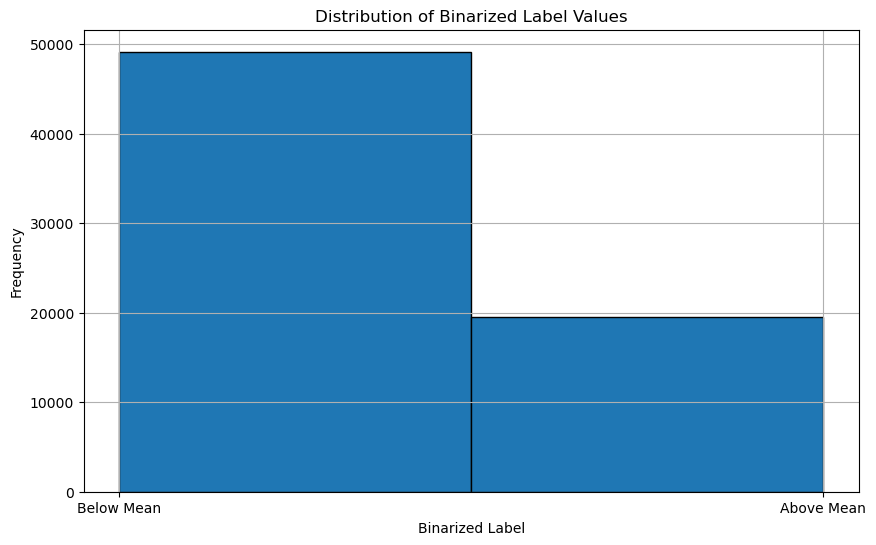

In [87]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df['binarized_label'], bins=2, edgecolor='black')
plt.title('Distribution of Binarized Label Values')
plt.xlabel('Binarized Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Below Mean', 'Above Mean'])
plt.grid(True)
plt.show()